In [1]:
# create modeling spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName('Project 2')
    .config('spark.sql.repl.eagerEval.enabled', True) 
    .config('spark.sql.parquet.cacheMetadata', 'true')
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "8g")
    .config("spark.driver.memory", "8g")
    .getOrCreate()
)
import pandas as pd
from pyspark.sql import functions as F
import pathlib
import matplotlib.pyplot as plt

In [2]:
# create directory of rank folder
pathlib.Path("../data/curated/rank").mkdir(parents=True, exist_ok=True)

In [3]:
data = spark.read.parquet('../data/curated/final_dataset')

Use annual transaction count to predict future revenue

In [4]:
clean_transaction = spark.read.parquet('../data/curated/clean_full_dataset')
annual_transaction_count = clean_transaction.filter(F.col("order_datetime")>"2021-08-27")
annual_merchant_transaction = annual_transaction_count.groupby("merchant_abn").count().select("merchant_abn", "count")
full_data = data.join(annual_merchant_transaction, on="merchant_abn", how="left")


In [5]:
# calculate proportion of potential afterpay users
full_data = full_data.withColumn("ap_rate", (F.col("consumer_scaled_spare_money")*0.1+F.col("ap_percentage_by_gender").cast("float")))

In [6]:
busi_area_type = [
    "fashion", "fashion", "electronics", "recreation", 
    "recreation", "household", "recreation", "household",
    "recreation", "household", "electronics", "household",
    "recreation", "household", "household", "electronics",
    "fashion", "fashion", "recreation", "electronics",
    "recreation", "recreation", "household", "household", "household"]

busi_area= full_data.groupby('business_area').count().select("business_area").toPandas()['business_area'].to_list()


allocation_sdf=spark.createDataFrame(pd.DataFrame(list(zip(busi_area, busi_area_type)),
               columns =['business_area', 'business_segment']))

full_data = full_data.join(allocation_sdf, on = "business_area")

In [7]:
# calculate expected transaction counts for next year
full_data = full_data.withColumn("expected_transaction", (F.col("count")*
                                 (1+F.col("annual_turnover_percentage")/100)).cast("int"))

In [8]:
# there are ap_rate of less than 0, replace this rate by 0.001
full_data = full_data.withColumn("ap_rate", F.when(full_data["ap_rate"] < 0, 0.001).otherwise(full_data["ap_rate"]))

In [9]:
# afterpay user = transaction*1.077*aprate
full_data = full_data.withColumn("expected_revenue", \
                        ((F.col("expected_transaction")*1.077*F.col("ap_rate")).cast("int")\
                        *F.col("avg_total_value"))*F.col("take_rate")/100)

In [10]:
ranking = full_data.select("merchant_abn", "name", "business_area", "expected_revenue", "avg_total_value",\
                           "fraud_rate", "ap_rate", "revenue_level", "business_segment", "expected_transaction")

In [11]:
ranking = ranking.withColumn("true_revenue", (F.col("expected_revenue")*(1-F.col("fraud_rate"))))\
                .orderBy(F.col("true_revenue").desc())

In [12]:
ranking = ranking.drop("expected_revenue", "fraud_rate", "ap_rate")
ranking.write.mode("overwrite").parquet("../data/curated/rank/ranking/")


In [13]:
household_rank = ranking.filter(F.col("business_segment")=="household").orderBy(F.col("true_revenue").desc())
household_rank.write.mode("overwrite").parquet("../data/curated/rank/household_rank/")


In [14]:
recreation_rank = ranking.filter(F.col("business_segment")=="recreation").orderBy(F.col("true_revenue").desc())
recreation_rank.write.mode("overwrite").parquet("../data/curated/rank/recreation_rank/")


In [15]:
electronic_rank = ranking.filter(F.col("business_segment")=="electronics").orderBy(F.col("true_revenue").desc())
electronic_rank.write.mode("overwrite").parquet("../data/curated/rank/electronic_rank/")


In [16]:
fashion_rank = ranking.filter(F.col("business_segment")=="fashion").orderBy(F.col("true_revenue").desc())
fashion_rank.write.mode("overwrite").parquet("../data/curated/rank/fashion_rank/")

Top 100 merchants

In [17]:
top100 = ranking.limit(100)
top100.limit(10)

merchant_abn,name,business_area,avg_total_value,revenue_level,business_segment,expected_transaction,true_revenue
32361057556,Orci In Consequat...,"gift, card, novel...",109.98738471647025,a,recreation,65016,43766.742919312244
45629217853,Lacus Consulting,"gift, card, novel...",36.86309255250773,a,recreation,173438,42207.57778690396
96680767841,Ornare Limited,motor vehicle sup...,315.06861309524027,a,household,23763,39728.91708258423
21439773999,Mauris Non Institute,"cable, satellite,...",78.14540729233093,a,electronics,91406,39120.00430848647
89726005175,Est Nunc Consulting,tent and awning s...,41.23187459923756,a,household,163743,38512.82005309113
64403598239,Lobortis Ultrices...,music shops - mus...,78.11269321474416,a,recreation,85967,38210.088844639424
48534649627,Dignissim Maecena...,"opticians, optica...",141.65798620362992,a,fashion,48309,37992.51900873453
67978471888,Magna Malesuada C...,artist supply and...,648.8876206534682,a,recreation,9454,36923.284896821715
38700038932,Etiam Bibendum In...,tent and awning s...,1336.2436316547887,a,household,5411,36430.26875071515
86578477987,Leo In Consulting,"watch, clock, and...",34.98176268056113,a,fashion,173786,36308.45974929885


In [47]:
top100.select(F.col("true_revenue")).toPandas().sum().round()

true_revenue    2205746.0
dtype: float64

Top 10 merchants for each segment

In [18]:
top10fashion = fashion_rank.limit(10)
top10electric = electronic_rank.limit(10)
top10recreation = recreation_rank.limit(10)
top10household = household_rank.limit(10)

In [19]:
top10household

merchant_abn,name,business_area,avg_total_value,revenue_level,business_segment,expected_transaction,true_revenue
96680767841,Ornare Limited,motor vehicle sup...,315.06861309524027,a,household,23763,39728.91708258423
89726005175,Est Nunc Consulting,tent and awning s...,41.23187459923756,a,household,163743,38512.82005309113
38700038932,Etiam Bibendum In...,tent and awning s...,1336.2436316547887,a,household,5411,36430.26875071515
80551528183,Ac Ipsum LLC,tent and awning s...,1125.4718484638406,b,household,5919,31630.093244327345
76767266140,Phasellus At Limited,"furniture, home f...",214.48522155694192,b,household,31572,30628.084659145745
49549583265,Luctus Et Incorpo...,tent and awning s...,678.704234522669,a,household,7611,30100.626867241706
79827781481,Amet Risus Inc.,"furniture, home f...",2036.4814449572925,a,household,3442,28800.457005251534
49891706470,Non Vestibulum In...,tent and awning s...,28.980731305967698,a,household,187350,28426.296434780867
43186523025,Lorem Ipsum Sodal...,florists supplies...,44.99407448848733,b,household,152011,28308.977410753636
90568944804,Diam Eu Dolor LLC,tent and awning s...,898.5753673253311,b,household,8157,26953.984708165714


In [20]:
top10recreation

merchant_abn,name,business_area,avg_total_value,revenue_level,business_segment,expected_transaction,true_revenue
32361057556,Orci In Consequat...,"gift, card, novel...",109.98738471647025,a,recreation,65016,43766.742919312244
45629217853,Lacus Consulting,"gift, card, novel...",36.86309255250773,a,recreation,173438,42207.57778690396
64403598239,Lobortis Ultrices...,music shops - mus...,78.11269321474416,a,recreation,85967,38210.088844639424
67978471888,Magna Malesuada C...,artist supply and...,648.8876206534682,a,recreation,9454,36923.284896821715
94493496784,Dictum Phasellus ...,"gift, card, novel...",91.89829533112882,a,recreation,75281,36284.53364046986
40515428545,Elit Sed Consequa...,artist supply and...,596.5734154604642,a,recreation,9881,34353.536434727845
63123845164,Odio Phasellus In...,artist supply and...,751.2370990170103,a,recreation,8641,33735.956793983576
79417999332,Phasellus At Company,"gift, card, novel...",91.9414464701124,b,recreation,75447,33074.7818877211
72472909171,Nullam Consulting,digital goods: bo...,70.31518680234745,a,recreation,77204,32167.069700367047
27326652377,Tellus Aenean Cor...,music shops - mus...,1009.5896252964578,a,recreation,4910,30423.656221079513


In [21]:
top10fashion

merchant_abn,name,business_area,avg_total_value,revenue_level,business_segment,expected_transaction,true_revenue
48534649627,Dignissim Maecena...,"opticians, optica...",141.65798620362992,a,fashion,48309,37992.51900873453
86578477987,Leo In Consulting,"watch, clock, and...",34.98176268056113,a,fashion,173786,36308.45974929885
49322182190,Gravida Mauris In...,"watch, clock, and...",151.2973045284807,a,fashion,33009,28798.587560997054
19492220327,Commodo Ipsum Ind...,"jewelry, watch, c...",9997.797797783242,b,fashion,649,20767.51858832556
11439466003,Blandit At LLC,shoe shops,163.07968880593438,a,fashion,22619,20088.496428337545
93558142492,Dolor Quisque Inc.,shoe shops,405.6866231203035,b,fashion,16544,18853.320486544595
95574756848,At Pede Inc.,"opticians, optica...",357.41601111620497,a,fashion,8266,17358.93264217874
99976658299,Sociosqu Corp.,shoe shops,149.92402158371087,a,fashion,17440,16660.979479032503
46804135891,Suspendisse Dui C...,"opticians, optica...",29.98490952653827,c,fashion,170658,13434.684057044793
81761494572,Nulla Facilisis I...,"watch, clock, and...",115.0319859686225,a,fashion,16826,13369.956102551712


In [22]:
top10electric

merchant_abn,name,business_area,avg_total_value,revenue_level,business_segment,expected_transaction,true_revenue
21439773999,Mauris Non Institute,"cable, satellite,...",78.14540729233093,a,electronics,91406,39120.00430848647
35909341340,Arcu Sed Eu Incor...,computer programm...,250.7705228080561,b,electronics,26338,32279.682572125555
45433476494,Adipiscing Elit F...,"computers, comput...",450.93672527389566,a,electronics,12121,31161.95303567217
82368304209,Nec Incorporated,telecom,1867.954943974729,a,electronics,3720,31146.11606194541
94690988633,Eu Placerat LLC,"computers, comput...",202.0520362068834,a,electronics,23614,27964.158872441658
58454491168,Diam At Foundation,computer programm...,251.55068227498938,a,electronics,18454,24132.20391261745
80518954462,Neque Sed Dictum ...,"computers, comput...",300.97378136636956,b,electronics,22628,23198.08590220679
34096466752,Nullam Enim Ltd,"computers, comput...",500.5880908303476,b,electronics,14008,21165.01895563647
67400260923,Eleifend PC,computer programm...,149.812854422409,a,electronics,25908,20027.85742375301
77590625261,Sed Diam Foundation,computer programm...,301.96276795289305,b,electronics,17412,16560.265927804096


In [23]:
top100_df = top100.select("revenue_level").groupby("revenue_level").count().toPandas()

top100_df

,revenue_level,count
0,a,50
1,b,39
2,c,11


In [24]:
full_data.filter(F.col("revenue_level")=="e").orderBy(F.col("take_rate").desc())

business_area,merchant_abn,business_area_type,total_transactions_count,avg_total_value,name,revenue_level,take_rate,consumer_scaled_spare_money,ap_percentage_by_gender,annual_turnover_percentage,fraud_rate,count,ap_rate,business_segment,expected_transaction,expected_revenue
shoe shops,45663905997,Retail trade,1846,409.7789910024507,Lacus Mauris Asso...,e,0.48,-0.6073911267776049,0.08536782231852655,21.9,0.002708559046587...,1298,0.024628708479218116,fashion,1582,80.64450542928229
tent and awning s...,33226000026,Retail trade,943,1176.0788257950946,Quis Turpis Corp.,e,0.48,0.2266192907975403,0.08407688229056204,21.9,0.04772004241781548,666,0.10673881048844544,household,811,525.0015878349302
antique shops - s...,41424526968,Retail trade,952,213.82587432490465,Elit Consulting,e,0.47,-1.2829118234620451,0.08646113445378151,21.9,0.002100840336134...,671,0.001,household,817,0.0
"books, periodical...",28517327395,Retail trade,932,364.286655368395,Pede Blandit LLP,e,0.47,-0.5705125688510309,0.08556545064377682,21.9,0.006437768240343348,662,0.028514190922208922,recreation,806,41.09153472555495
shoe shops,28504709344,Retail trade,73,337.44485976125577,Consequat Corp.,e,0.47,0.15316116835638535,0.08717123287671232,21.9,0.0136986301369863,48,0.10248735102610255,fashion,58,9.515945045267413
motor vehicle sup...,47524805326,Retail trade,466,325.6629838664739,Gravida Nunc Inc.,e,0.46,0.12908867327906604,0.08347103004291845,21.9,0.006437768240343348,331,0.09637989732477856,household,403,61.42003875721698
artist supply and...,72780061668,Retail trade,35,914.6871094104937,Mattis Velit Just...,e,0.45,0.19286779523502,0.08375714285714286,21.9,0.05714285714285714,24,0.10304391926587642,recreation,29,12.348275977041665
shoe shops,99018524323,Retail trade,817,247.11640163433853,Orci Consectetuer...,e,0.42,0.16261442167325385,0.08658261933904529,21.9,0.006119951040391677,577,0.10284405813889064,fashion,703,79.91744428854507
florists supplies...,48666632255,Retail trade,79,392.71949903735765,Aliquam Nec Enim LLP,e,0.42,0.012362883596388857,0.08743037974683546,21.9,0.012658227848101266,58,0.08866666864442511,household,70,9.89653137574141
computer programm...,64928973842,"Professional, sci...",365,320.36098636583995,Sed Company,e,0.41,-0.01169741756257...,0.08792328767123289,11.3,0.005479452054794521,252,0.08675354658907955,electronics,280,34.15048114659854


In [25]:
full_data.filter(F.col("revenue_level")=="a").orderBy(F.col("take_rate").asc())

business_area,merchant_abn,business_area_type,total_transactions_count,avg_total_value,name,revenue_level,take_rate,consumer_scaled_spare_money,ap_percentage_by_gender,annual_turnover_percentage,fraud_rate,count,ap_rate,business_segment,expected_transaction,expected_revenue
"stationery, offic...",36662964956,Retail trade,39,529.2581920267878,Curabitur Associates,a,5.50,0.45837246678495003,0.0776794871794872,21.9,0.02564102564102564,28,0.12351673176112135,household,34,116.43680224589332
computer programm...,15937271532,"Professional, sci...",333,298.3888091718008,Diam Proin Dolor ...,a,5.50,0.027219465631823505,0.08540840840840841,11.3,0.006006006006006006,248,0.088130358483253,electronics,276,426.69599711567514
bicycle shops - s...,62583219931,Retail trade,7679,148.83980565795954,Mi Lacinia Mattis...,a,5.50,0.0630210310002075,0.08515841906498244,21.9,0.003906758692538091,5442,0.09146052568932281,household,6633,5345.581620205618
florists supplies...,74024744735,Retail trade,478,446.3800860125984,Eu LLP,a,5.51,0.0831367499455325,0.08556380753138074,21.9,0.004184100418410...,335,0.09387748367413394,household,408,1008.4172523110609
computer programm...,73895811023,"Professional, sci...",2978,100.4109335312474,Libero Mauris Ali...,a,5.51,0.2123792634828312,0.0860530557421088,11.3,0.004365345869711216,2152,0.1072909848533414,electronics,2395,1527.009312769798
"stationery, offic...",58596147982,Retail trade,413,403.4404615956827,Rutrum Lorem Inc.,a,5.51,0.1703610396221989,0.0852046004842615,21.9,0.004842615012106538,274,0.10224070525006168,household,334,800.2644996211961
bicycle shops - s...,52594457116,Retail trade,6800,510.6094922285751,Vel Turpis Aliqua...,a,5.51,-0.5797955047373281,0.08514566176470588,21.9,0.0125,4798,0.027166109271006718,household,5848,4811.013696726857
"cable, satellite,...",41974958954,Retail trade,18390,58.9574961441794,Sed Libero Proin ...,a,5.51,-0.01290240989087...,0.08515171288743882,21.9,0.003806416530723...,13096,0.08386146862709686,electronics,15964,4681.172132101315
computer programm...,64732735902,"Professional, sci...",6428,200.50988384720088,Imperdiet Non Ves...,a,5.51,-0.13221250203323856,0.08486893279402613,11.3,0.004511512134411947,4523,0.07164768007688473,electronics,5034,4286.660704792538
lawn and garden s...,17610103622,Retail trade,15,1990.557837897359,Per Conubia Corpo...,a,5.51,-0.02057747121902...,0.09159999999999999,21.9,0.13333333333333333,12,0.08954225373640402,household,14,109.67973686814446


In [27]:
top100_df

,revenue_level,count
0,a,50
1,b,39
2,c,11


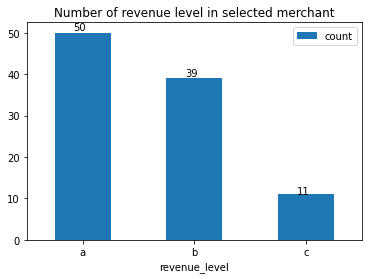

In [75]:
ax = top100_df.plot.bar(x = "revenue_level", rot=0, 
                        title='Number of revenue level in selected merchant')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width()/3, p.get_height()*1.01))
fig = ax.get_figure()
fig.savefig("../plots/Number of revenue level in selected merchant.png")


<Figure size 432x288 with 0 Axes>

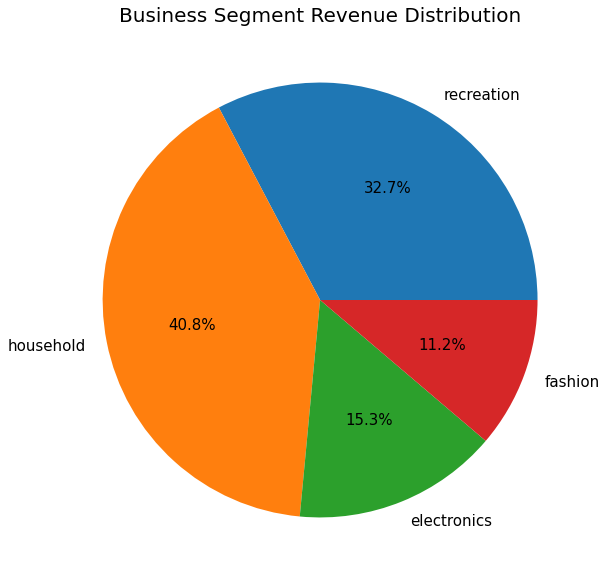

<Figure size 432x288 with 0 Axes>

In [72]:
top100_revenue_distribution = top100.select("business_segment", "true_revenue")\
                                                        .groupby("business_segment").sum().toPandas()
top100_revenue_distribution = top100_revenue_distribution.rename(columns={"sum(true_revenue)":"total revenue"})
top100_revenue_distribution = top100_revenue_distribution.set_index("business_segment")

ax = top100_revenue_distribution.plot.pie(y='total revenue', figsize=(10, 10), \
                                                           legend=False, autopct='%1.1f%%', \
                                                            shadow=False, fontsize = 15,  ylabel = "")

ax.set_title("Business Segment Revenue Distribution", fontdict={'fontsize':20})

plt.savefig("../plots/Business segment revenue distribution.png")
plt.figure()



<Figure size 432x288 with 0 Axes>

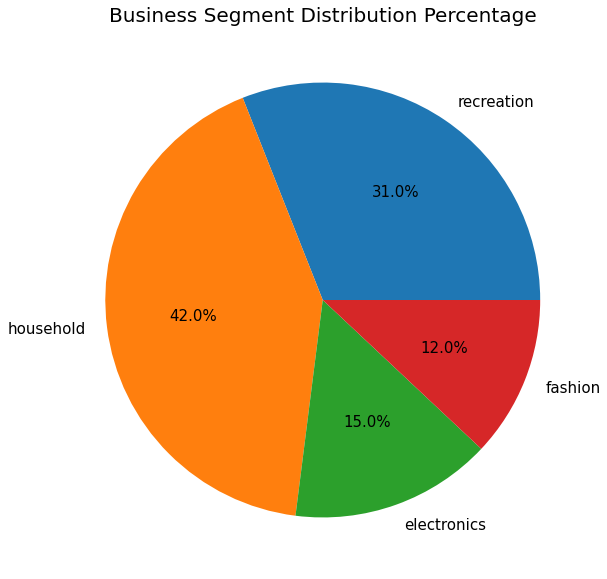

<Figure size 432x288 with 0 Axes>

In [73]:
top100_segment_distribution = top100.select("business_segment").groupby("business_segment").count().toPandas()
top100_segment_distribution = top100_segment_distribution.set_index("business_segment")
ax = top100_segment_distribution.plot.pie(y='count', \
                                        figsize=(10, 10),\
                                        legend=False, autopct='%1.1f%%', shadow=False, startangle=0,\
                                        fontsize = 15,  ylabel = "")

ax.set_title("Business Segment Distribution Percentage", fontdict={'fontsize':20})

plt.savefig("../plots/Business segment distribution.png")
plt.figure()



In [52]:
top10_all_segment = top10fashion.union(top10electric)
top10_all_segment = top10_all_segment.union(top10recreation)
top10_all_segment = top10_all_segment.union(top10household)

In [53]:
top10_all_segment.select(F.col("true_revenue")).toPandas().sum().round()

true_revenue    1171057.0
dtype: float64

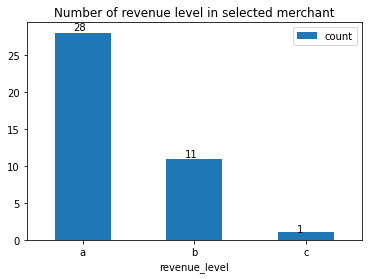

In [82]:
top10_all_segment_df = top10_all_segment.select("revenue_level").groupby("revenue_level")\
                        .count().orderBy("revenue_level").toPandas()

ax = top10_all_segment_df.plot.bar(x = "revenue_level", rot=0, 
                        title='Number of revenue level in selected merchant')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width()/3, p.get_height()*1.01))
fig = ax.get_figure()
fig.savefig("../plots/Number of revenue level in selected merchant(top 10).png")

In [81]:
top10_all_segment_df

,revenue_level,count
0,c,1
1,b,11
2,a,28


<Figure size 432x288 with 0 Axes>

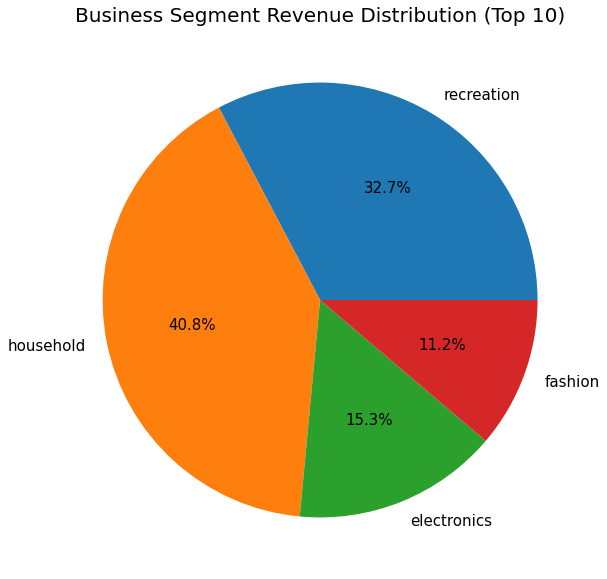

<Figure size 432x288 with 0 Axes>

In [83]:
top10_all_revenue_distribution = top10_all_segment.select("business_segment", "true_revenue")\
                                                        .groupby("business_segment").sum().toPandas()
top10_revenue_distribution = top10_all_revenue_distribution.rename(columns={"sum(true_revenue)":"total revenue"})
top10_revenue_distribution = top10_revenue_distribution.set_index("business_segment")

ax = top100_revenue_distribution.plot.pie(y='total revenue', figsize=(10, 10), \
                                                           legend=False, autopct='%1.1f%%', \
                                                            shadow=False, fontsize = 15,  ylabel = "")

ax.set_title("Business Segment Revenue Distribution (Top 10)", fontdict={'fontsize':20})

plt.savefig("../plots/Business segment revenue distribution(top 10).png")
plt.figure()




### Introduction
The Buy Now & Pay Later (BNPL) project we are working on is a project that helps companies like After 
Pay and other online financial business company to find better client merchant and increase their total 
profits with limited resources available.

In order to find the best client merchants, we are looking for, we need to develop a ranking system to 
output the top 100 merchants and we also separate the merchants into four segments with business 
areas and ranked the top-10 merchants in the business area.

We have the available dataset from After Pay of the merchant list, customer list and the transaction 
between merchant and customers. The merchants have features line their annual revenue level, the 
take rate After pay is going to charge in each transaction, and their business areas.
The additional dataset we used is a turnover dataset form ABS database and a census data and the 
annual report from the After Pay company.


### Preprocessing
Data cleaning

Null value evaluation

Data merge with key

Select merchants with reasonable amount of transaction

Convert POS code in ABS data to post code and relate to customer (leftover merge)

Data normalization

Outlier detection and removal

### Ranking Algorithm 

The merchants are ranked by expected revenue:

**expected revenue = ap_rate * total_transaction_count * avg_transaction_amount * take_rate_revenue**.

where 

**ap_rate** is the percentage of customers who are likely to use afterpay for their orders, which is calculated combining customer gender, rent and income based on their recorded postcode;

**total_transaction_count** is the expected count of transactions of this merchant after cooparated with BNPL company, (i.e. there will be a 7% increasing on transactions statistically);

**avg_transaction_amount** is the average amount of existing transactions for this merchant;

**take_rate_revenue** is the provided rate of total transaction amount that is the revenue of BNPL company.

We separate the merchants into 3 segments according to their business area as follows:

##### Recreation:
-digital goods: books, movies, music  
-health and beauty spas  
-hobby, toy and game shops  
-gift, card, novelty, and souvenir shops  
-books, periodicals, and newspapers  
-art dealers and galleries  
-music shops - musical instruments, pianos, and sheet music  
-artist supply and craft shops  


##### Electronics:
-computer programming , data processing, and integrated systems design services  
-cable, satellite, and other pay television and radio services  
-computers, computer peripheral equipment, and software  
-telecom  


##### Household:
-antique shops - sales, repairs, and restoration services  
-furniture, home furnishings and equipment shops, and manufacturers, except appliances  
-tent and awning shops  
-equipment, tool, furniture, and appliance rent al and leasing  
-lawn and garden supply outlets, including nurseries  
-florists supplies, nursery stock, and flowers  
-bicycle shops - sales and service  
-motor vehicle supplies and new parts

### Discussion

##### Distribution of revenue level in selected merchants
It is noticed that the merchants with revenue level a are most favoured amongst all merchants whereas no merchants with revenue level d and e is selected in top 100 merchants. This implys that revenue level is one of the most important feature in the selection of merchants with the highest potential benefit to cooperate with. 

#### Business segment revenue distribution
The pie graph demonstrates that the most revenue comes from household and creation segment, whereas the merchants of fashion segment provides the least potential revenue. 

#### Business segment merchant distribution
g